# Quality Assessment

In [ ]:
import pandas as pd

Load our cleaned DataFrames

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [ ]:
#pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### Include only acual purchases
No `shopping cart`, `cancelled` etc...

Let's create a copy of the `orders_cl` DataFrame, to make sure any of our changes won't affect the original DataFrame.

In [ ]:
actual_purchases_df = orders_cl.copy()

Let's look at the make up of `state`.

In [ ]:
actual_purchases_df.state.value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

Seems like an ovewhelming amount of the orders are left in the shopping basket - something we'll have to analyse another time. For this task we're interested in only `completed` orders, so let's filter our DataFrame.

In [ ]:
actual_purchases_df = actual_purchases_df.loc[actual_purchases_df['state'].isin(["Completed"]), :]

Next, we'll make a list of the `order_id`'s of the `Completed` orders.

In [ ]:
actual_purchases_list = list(actual_purchases_df["order_id"])

Now we can filter our cleaned DataFrames to include only the `order_id`'s in the list we just made. We'll also change the DataFrames from `_cl` to `_qu`, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.

In [ ]:
orders_qu = orders_cl.loc[orders_cl["order_id"].isin(actual_purchases_df["order_id"]), :].copy()

In [ ]:
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(actual_purchases_list), :].copy()

### Keep only the orders that are present in both `orders` and `orderlines`
Let's begin by looking if there's a big difference between the amount of orders present in `orders` and `orderlines`.

In [ ]:
len(orders_qu.order_id.unique())

46605

In [ ]:
len(orderlines_qu.id_order.unique())

43064

Approximately 3000 difference!!! Let's fix that. We'll perform an inner merge on the two tables using the `order_id` & `id_order`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [ ]:
orders_lines_merged_df = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [ ]:
orders_lines_merged_df.head(5)

,order_id,created_date,total_paid,state,id,id_order,product_id,product_quantity,sku,unit_price,date
0,241423,2017-11-06 13:10:02,136.15,Completed,1398738,241423,0,1,LAC0212,129.16,2017-11-06 12:47:20
1,242832,2017-12-31 17:40:03,15.76,Completed,1529178,242832,0,1,PAR0074,10.77,2017-12-31 17:26:40
2,243330,2017-02-16 10:59:38,84.98,Completed,1181923,243330,0,1,OWC0074,77.99,2017-02-15 17:07:44
3,245275,2017-06-28 11:35:37,149.00,Completed,1276706,245275,0,1,TAD0007,149.00,2017-06-28 11:12:30
4,245595,2017-01-21 12:52:47,112.97,Completed,1154394,245595,0,2,PAC1561,52.99,2017-01-21 12:49:00


In [ ]:
o_ids_in_both_list = list(orders_lines_merged_df["order_id"].unique())

In [ ]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(o_ids_in_both_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["id_order"].isin(o_ids_in_both_list), :]

In [ ]:
print(f"orders_qu {orders_qu.shape[0]} orderlines_qu {orderlines_qu.shape[0]}")

orders_qu 43064 orderlines_qu 56714


Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

(43064, 43064)

In [ ]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56714 entries, 6 to 215949
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                56714 non-null  int64  
 1   id_order          56714 non-null  int64  
 2   product_id        56714 non-null  int64  
 3   product_quantity  56714 non-null  int64  
 4   sku               56714 non-null  object 
 5   unit_price        56714 non-null  float64
 6   date              56714 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.5+ MB


In [ ]:
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43064 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      43064 non-null  int64  
 1   created_date  43064 non-null  object 
 2   total_paid    43064 non-null  float64
 3   state         43064 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ MB


## 3.&nbsp; Exclude orders with unknown products
Let's start by making a list of known products.

In [ ]:
products_cl.head(10)

,sku,name,desc,price,in_stock,type
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,0,1387
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,0,1230
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,1,1364
5,APP0073,Apple Composite AV Cable iPhone and iPod white,IPhone and iPod AV Cable Dock to Composite Video.,45.00,0,1230
6,KIN0008,Mac Memory Kingston 1GB 667MHz DDR2 SO-DIMM,1GB RAM Mac mini and iMac (2006/07) MacBook Pr...,18.99,0,1364
7,KIN0009,Mac Memory Kingston 2GB 800MHz DDR2 SO-DIMM,2GB RAM iMac with Intel Core 2 Duo (Penryn).,36.99,0,1364
8,KIN0001-2,Mac memory Kingston 4GB (2x2GB) 667MHz DDR2 SO...,RAM 4GB (2x2GB) Mac mini and iMac (2006/07) Ma...,74.00,0,1364
9,APP0100,Apple Adapter Mini Display Port to VGA,Adapter Mini Display Port to VGA MacBook and M...,35.00,0,1325


In [ ]:
known_skus_list = list(products_cl["sku"])

Let's have a look to see how many products in our `orderlines_qu` DataFrame are known and how many are unknown.

In [ ]:
orderlines_qu.sku.isin(known_skus_list).value_counts()

True     55320
False     1394
Name: sku, dtype: int64

Looks like the vast majority of products are known. 

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product. 

The 1st step is to identify any order that contains an unknown product. Then find the `order_id` of these orders. Finally filter these order numbers out of our `_qu` DataFrames.

In [ ]:
orders_with_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(known_skus_list), "id_order"])

Now we can filter our DataFrame to exclude the `order_id`'s that contain unknown products

In [ ]:
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_with_unknown_products_list), :]
orderlines_qu = orderlines_qu.loc[~orderlines_qu["id_order"].isin(orders_with_unknown_products_list), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

(41701, 41701)

In [ ]:
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41701 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      41701 non-null  int64  
 1   created_date  41701 non-null  object 
 2   total_paid    41701 non-null  float64
 3   state         41701 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54324 entries, 6 to 215949
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54324 non-null  int64  
 1   id_order          54324 non-null  int64  
 2   product_id        54324 non-null  int64  
 3   product_quantity  54324 non-null  int64  
 4   sku               54324 non-null  object 
 5   unit_price        54324 non-null  float64
 6   date              54324 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.3+ MB


## 4.&nbsp; Explore the revenue from different tables

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

#### Step 2: 
Group by `order_id`, summarising by the sum of `unit_price_total`

In [ ]:
orderlines_qu_group_order_df = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()

### What is the average difference between `total_paid` and `unit_price_total`?

In [ ]:
orders_qu_copy = orders_qu.copy()

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [ ]:
diff_df = orders_qu_copy.merge(orderlines_qu_group_order_df, 
                               how = 'inner',
                               left_on="order_id", 
                               right_on="id_order"
                               )

In [ ]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head()

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99


Now that we know the difference for each order, we can compute the average.

In [ ]:
diff_df.difference.mean().round(2)

4.47

### What is the distribution of these differences?

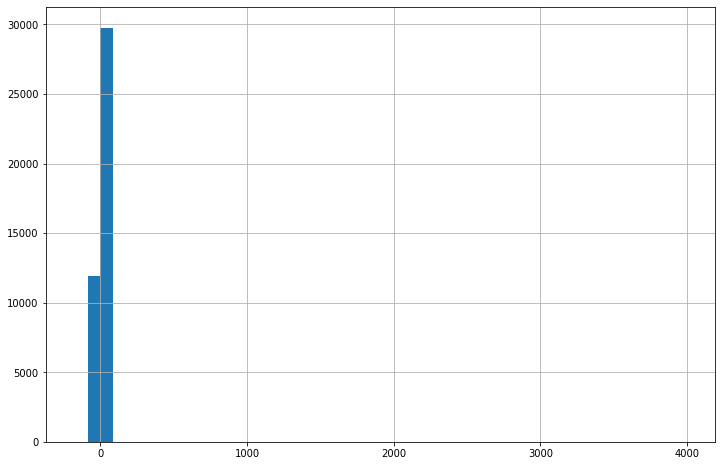

In [ ]:
diff_df.difference.hist(bins= 50, figsize=(12,8));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [ ]:
diff_df.difference.describe()

count    41701.000000
mean         4.474808
std         26.046478
min       -165.000000
25%          0.000000
50%          4.990000
75%          6.990000
max       3984.990000
Name: difference, dtype: float64

We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything: 
+ lower than the 25% quartile - (1.5 x interquartile range), or 
+ higher than the 75% quartile + (1.5 x interquartile range) 

is an outlier. Let's use this rule to try and exclude any corrupted data.

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[(diff_df["difference"] >= (Q1 - 1.5*IQR)) & (diff_df["difference"] <= (Q3 + 1.5*IQR))]

Let's look at the distribution again to see the affect of removing the outliers.

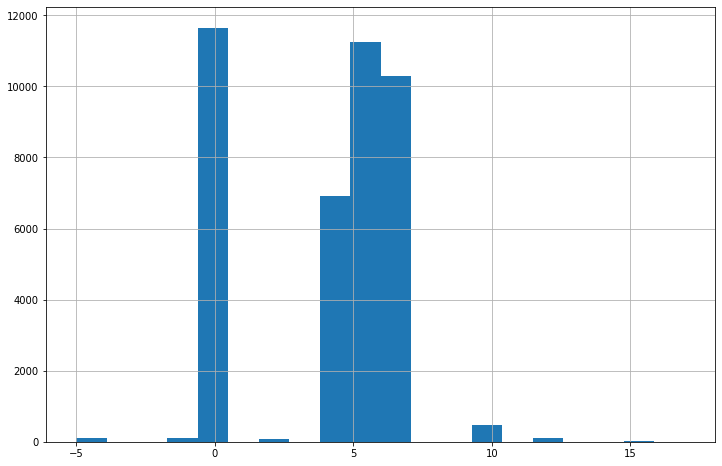

In [ ]:
diff_no_outliers_df.difference.hist(bins= 20, figsize=(12,8));

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [ ]:
normal_diff_list = list(diff_no_outliers_df["order_id"])

In [ ]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["id_order"].isin(normal_diff_list), :]

In [ ]:
len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

(40985, 40985)

In [ ]:
orders_qu.shape[0]

40985

In [ ]:
orderlines_qu.shape[0]

53231

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

In [3]:
# orders –> Keep only orders with the states that you want to work with!

In [4]:
# making sure that data coming from different tables are either consistent or excluded from your dataset.

Let's not forget to download our quality controlled DataFrames

In [ ]:
from google.colab import files

orders_qu.to_csv("orders_qu.csv", index=False)
files.download("orders_qu.csv")

orderlines_qu.to_csv("orderlines_qu.csv", index=False)
files.download("orderlines_qu.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>